In [1]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import re

# Data processing: Join PHQ9, GAD7 and ACE datasets together by record_id and redcap_event_name

In [2]:
data = data_load(data_keys={'phq9', 'generalized_anxiety_disorder_scale_gad7', 'ace', 'surveys', 'study_ids', 'check_in_adherence_log'})

In [3]:
outcomes = pd.merge(data['phq9'], data['generalized_anxiety_disorder_scale_gad7'],  how='outer', left_on=['record_id','redcap_event_name'], right_on = ['record_id','redcap_event_name'])

In [4]:
overall_df = pd.merge(data['ace'].drop(columns=['redcap_event_name']).dropna(), outcomes, how='left', on='record_id')

# Convert redcap_event_name to date for PHQ9, GAD7 and ACE datasets

In [5]:
# read study ids
id_df = data['study_ids'][['record_id', 'evidation_id']]
id_df.rename(columns={'evidation_id': 'user_id'}, inplace=True)

# add ids to survey
overall_df = overall_df.merge(id_df, on=['record_id'])
overall_df.user_id = overall_df.user_id.fillna(-1).astype(int)

# standarize naming convention for easier processing later on
overall_df.redcap_event_name = overall_df.redcap_event_name.replace('postnatal_checkin_arm_1','postnatal_ci_1_arm_1')

In [6]:
# read check-in dates
ci_df = data['check_in_adherence_log']
cols = ['record_id'] + [col for col in ci_df.columns if '_date' in col]
ci_df = ci_df[cols]

# standarize naming convention for easier processing later on
ci_df = ci_df.rename(columns={'checkin_postnatal_date': 'checkin_postnatal_date_1'})

# add dates to survey, need to map it using the check_in_adherence_log
def conver_checkin_string(x):
    x = x.split('_arm')[0] #delete all characters after the word 'arm'
    num = int(re.search(r'\d+', x).group())
    if 'postnatal' in x:
        return f'checkin_postnatal_date_{num}'
    else:
        return f'checkin_{num}_date'

# map checkin_postnature_date_{num} OR checkin_{num}_date to the actual date
def map_date(x):
    checkin_string_col = x['checkin_string']
    return x[checkin_string_col]

overall_df = overall_df.merge(ci_df, on=['record_id'])
overall_df['checkin_string'] = overall_df.redcap_event_name.apply(conver_checkin_string)
overall_df['date'] = overall_df.apply(map_date, axis=1)
overall_df = overall_df[overall_df.columns.drop(list(overall_df.filter(regex='checkin_')))]
overall_df['date'] = pd.to_datetime(overall_df['date'])

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
overall_df.loc[overall_df['record_id'] == 28][['date', 'redcap_event_name']] #check if dates are correctly processed

,date,redcap_event_name
203,2021-04-30,ci_1_arm_1
204,2021-05-11,ci_2_arm_1
205,2021-05-25,ci_3_arm_1
206,2021-06-08,ci_4_arm_1
207,2021-06-22,ci_5_arm_1
208,2021-08-02,ci_8_arm_1
209,2021-08-17,ci_9_arm_1
210,2021-09-07,ci_10_arm_1
211,2021-10-01,postnatal_ci_1_arm_1
212,2021-10-26,postnatal_ci_2_arm_1


# Add Global survey data - PROMIS quality of life

In [8]:
promis_survey = data['surveys']
promis_survey = promis_survey.loc[promis_survey['question_id'] == 121]
promis_survey['date'] = pd.to_datetime(promis_survey['date'])

In [9]:
promis_survey['question_text'].unique()

array(['In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?'],
      dtype=object)

In [10]:
promis_survey['answer_text'].unique()

array(['Never', 'Rarely', 'Sometimes', 'Often', 'Always'], dtype=object)

In [11]:
promis_survey.loc[promis_survey['user_id'] == 28]

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,date
222517,42274,28,11,Global survey,2021-04-27 00:00:00,2021-04-27 22:00:00,2021-04-28 01:00:00,2021-04-27 04:05:23.974126,2021-04-27 22:13:58.456141,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-04-27
222522,70479,28,11,Global survey,2021-05-25 00:00:00,2021-05-25 22:00:00,2021-05-26 01:00:00,2021-05-25 04:05:38.04252,2021-05-25 22:01:50.393004,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-05-25
222559,112393,28,11,Global survey,2021-06-22 00:00:00,2021-06-22 22:00:00,2021-06-23 01:00:00,2021-06-22 05:07:02.791691,2021-06-22 22:02:06.555992,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-06-22
222749,497891,28,11,Global survey,2021-11-09 00:00:00,2021-11-09 05:00:00,2021-11-10 05:00:00,2021-11-09 05:10:22.060597,2021-11-09 18:39:56.79676,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-11-09
222800,17445,28,11,Global survey,2021-03-02 00:00:00,2021-03-02 23:00:00,2021-03-03 02:00:00,2021-03-02 05:05:12.924307,2021-03-02 23:02:29.913693,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-03-02
222804,24712,28,11,Global survey,2021-03-30 00:00:00,2021-03-30 22:00:00,2021-03-31 01:00:00,2021-03-30 05:05:15.752291,2021-03-30 22:03:08.22026,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-03-30
222825,397784,28,11,Global survey,2021-10-12 00:00:00,2021-10-12 04:00:00,2021-10-13 04:00:00,2021-10-12 05:08:41.803388,2021-10-12 18:43:19.486764,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-10-12
222847,170973,28,11,Global survey,2021-07-20 00:00:00,2021-07-20 04:00:00,2021-07-21 04:00:00,2021-07-20 05:13:18.264439,2021-07-20 13:29:23.240445,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-07-20
222910,310417,28,11,Global survey,2021-09-14 00:00:00,2021-09-14 04:00:00,2021-09-15 04:00:00,2021-09-14 05:07:56.145651,2021-09-14 17:57:05.426492,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Always,2021-09-14


# Process PHQ9, GAD and PROMIS data by taking the average over time for each individual

In [12]:
# # more balanced set up
# ace_levels = {
#     (0, 1) : 0,
#     (2, 10): 1
# }
# phq9_levels = {
#     (0, 4) : 0,
#     (5, 9): 1,
#     (10, 14): 1,
#     (15, 19): 1,
#     (20, 27): 1
# }
# gad_levels = {
#     (0, 4) : 0,
#     (5, 9): 1,
#     (10, 14): 1,
#     (15, 21): 1
# }
# promis_levels = {
#     "Always" : 1,
#     "Often": 1,
#     "Sometimes": 1,
#     "Rarely": 0,
#     "Never": 0
# }

# from literature
ace_levels = {
    (0, 4) : 0,
    (5, 10): 1
}
phq9_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 2,
    (15, 19): 3,
    (20, 27): 4
}
gad_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 2,
    (15, 21): 3
}
promis_levels = {
    "Always" : 4,
    "Often": 3,
    "Sometimes": 2,
    "Rarely": 1,
    "Never": 0
}
def map_levels(x, map_dict):
    for key in map_dict:
        if isinstance(x, str):
            if x == key:
                return map_dict[key]
        else:
            if x >= key[0] and x <= key[1]:
                return map_dict[key]

In [13]:
processed_overall_df = pd.DataFrame(columns=['user_id', 'ace_sum', 'phq9_sum', 'gad_sum', 'promis_mean'])
for uid in overall_df['user_id'].unique():
    each_df = overall_df.loc[overall_df['user_id']==uid]
    ace_lst = [f'ace_{x}' for x in range(1,11)]
    phq9_lst = [f'phq9_{x}' for x in range(1,11)]
    gad_lst = [f'gad_{x}' for x in range(1,9)]
    ace_sum = each_df[ace_lst].sum(axis=1)
    ace_sum_mean = ace_sum.apply(map_levels, map_dict=ace_levels).mean()
    phq9_sum = each_df[phq9_lst].sum(axis=1)
    phq9_sum_mean = phq9_sum.apply(map_levels, map_dict=phq9_levels).mean()
    gad_sum = each_df[gad_lst].sum(axis=1)
    gad_sum_mean = gad_sum.apply(map_levels, map_dict=gad_levels).mean()
    each_promis_df = promis_survey.loc[promis_survey['user_id']==uid]['answer_text'].apply(map_levels, map_dict=promis_levels)
    promis_mean = each_promis_df.mean()
    processed_overall_df = processed_overall_df.append({'user_id': uid, 'ace_sum': ace_sum_mean, 'promis_mean': promis_mean, 'phq9_sum': phq9_sum_mean, 'gad_sum': gad_sum_mean}, ignore_index=True)

In [14]:
processed_overall_df = processed_overall_df.dropna()

In [15]:
# processed_overall_df.to_csv('processed_causal_ace_4nodes_ref_levels_reverse.csv', index=False)

In [16]:
# processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] = processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] * 5

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a39e21y4 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<AxesSubplot:>

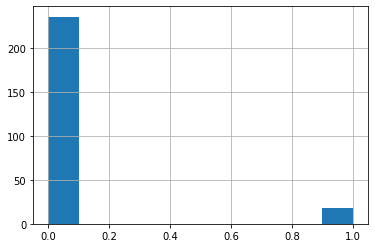

In [17]:
processed_overall_df['ace_sum'].hist()

<AxesSubplot:>

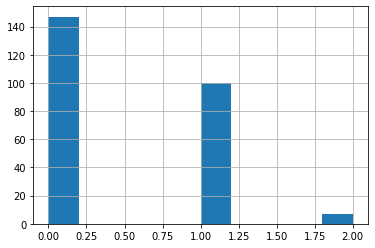

In [18]:
processed_overall_df['phq9_sum'].round().hist()

<AxesSubplot:>

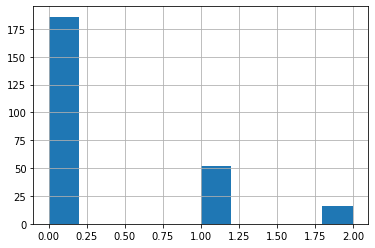

In [19]:
processed_overall_df['gad_sum'].round().hist()

<AxesSubplot:>

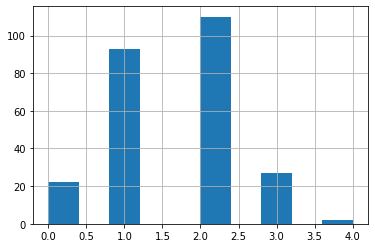

In [20]:
processed_overall_df['promis_mean'].round().hist()

In [21]:
processed_overall_df.head()

,user_id,ace_sum,phq9_sum,gad_sum,promis_mean
0,28.0,1.0,1.000000,1.357143,2.777778
1,29.0,0.0,1.384615,1.615385,2.714286
2,30.0,0.0,0.083333,0.333333,2.000000
3,31.0,0.0,1.333333,2.333333,3.000000
5,37.0,0.0,0.916667,0.500000,2.250000


In [22]:
import networkx
import notears.notears as notears
import matplotlib.pyplot as plt

data = processed_overall_df[['ace_sum', 'phq9_sum', 'gad_sum', 'promis_mean']].to_numpy().tolist()
output_dict = notears.run(notears.notears_standard, data, notears.loss.least_squares_loss, notears.loss.least_squares_loss_grad, e=1e-8, verbose=False)

In [23]:
print('Acyclicity loss: {}'.format(output_dict['h']))
print('Least squares loss: {}'.format(output_dict['loss']))

Acyclicity loss: 4.99631180872484e-09
Least squares loss: 0.7682701246247472


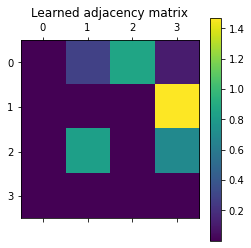

In [24]:
plt.matshow(output_dict['W'])
plt.title("Learned adjacency matrix")
plt.colorbar()

In [25]:
acyclic_W = notears.utils.threshold_output(output_dict['W'])

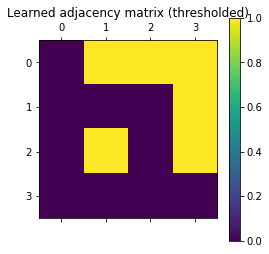

In [26]:
plt.matshow(acyclic_W)
plt.title("Learned adjacency matrix (thresholded)")
plt.colorbar()

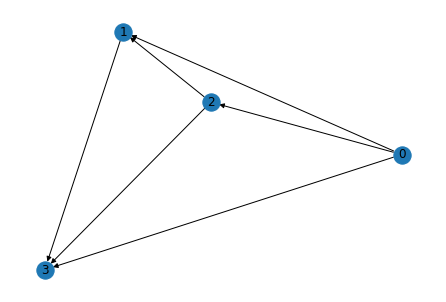

In [27]:
G = networkx.DiGraph(acyclic_W)
networkx.draw(G, with_labels=True)


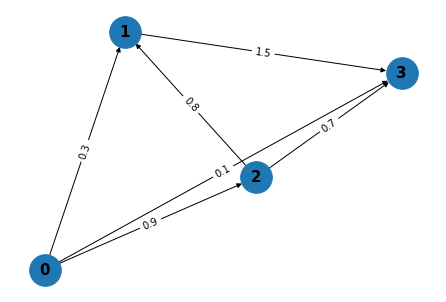

In [28]:
weighted_G = networkx.DiGraph((output_dict['W'] * acyclic_W).round(1))
layout = networkx.spring_layout(weighted_G)
networkx.draw(weighted_G, layout, node_size=1000, with_labels=True, font_weight='bold',    font_size=15)
labels = networkx.get_edge_attributes(weighted_G,'weight')
networkx.draw_networkx_edge_labels(weighted_G,pos=layout,edge_labels=labels)
plt.show()